In [1]:
import os,sys, operator
import shutil, gzip, math
import pickle
import numpy as np                                       # fast vectors and matrices
from glob import glob
from time import time
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
from torch import tensor
from torch import nn
import torch.nn.functional as F

from pathlib import Path
from IPython.core.debugger import set_trace
from collections import Counter

%matplotlib inline

## Data Loader

In [4]:
train_feat_path="processed_dataset\\train\\feat\\"
train_label_path="processed_dataset\\train\\label\\"
test_feat_path="processed_dataset\\test\\feat\\"
test_label_path="processed_dataset\\test\\label\\"

train_name=os.listdir(train_feat_path)
test_name=os.listdir(test_feat_path)

In [5]:
class CustomTrainDataset(Dataset):
    def __init__(self, feat_path=train_feat_path , label_path=train_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

class CustomTestDataset(Dataset):
    def __init__(self, feat_path=test_feat_path , label_path=test_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        print(self.feat_path +self.img_labels[idx])
        return data, label
    
    def demo() :
        for indices in train :
            yield collate_fn(train_dataset[i] for i in indices)


In [6]:
train_dataset=CustomTrainDataset()
test_dataset=CustomTrainDataset()

## model

In [7]:
class Model(nn.Module):
    # number of input feature, number of hidden feature, number of output feature
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        #self.fc = (32, 1500*120)
        #self.fc = (1500, 120)
        # data size = 32, 1500, 120
        #set_trace()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)] 
        print(self.layers)       
    def __call__(self, x):
        for k in self.layers:
            x = k(x)
        return x

def normalize(x, m, s): 
    return (x-m)/s

In [25]:
from sklearn.metrics import mean_squared_error
from torch import nn
loss = nn.MSELoss()

In [31]:
def M_accuracy(yhat, y):
    predictions = yhat.detach().numpy()
    true_values = y.detach().numpy()
    #predictions = (predictions >=0.5) 
    correct = ((predictions >=0.5) == true_values)
    return correct.mean().item()

def M_loss_func(yhat,y):
    predictions = yhat
    true_values = y
    #predictions = (predictions >=0.5) 
    
    return loss(true_values, predictions)
    return mean_squared_error(true_values,predictions).item() 

    
    predictions = yhat
    true_values = y
    return torch.where(true_values==1, 1-predictions, predictions).mean()


learing rate : .001/3/3/3  -> (tensor(-0.8370, grad_fn=<MeanBackward0>), 0.7207684659090909)
learing rate : .001  -> (tensor(-5.2699e+11, grad_fn=<MeanBackward0>), 0.9682017045454545)
note miss : 32

เราต้องถ่วง weight โดยให้ค่าจากการตอบ 1 ถูก ดีกว่าค่าจากการตอบ 0 ถูก


In [10]:
batch=32
lr = 0.2#.001/3/3/3 
nh = 50
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)

In [11]:
d,l =next(iter(train))
c = l.max()
k, m=d[1].size()

In [12]:
model = Model(m, nh, l.size(dim=2)) #model = Model(120, nh, l.size(dim=2))
preds = model(d[0][0])

[Linear(in_features=120, out_features=50, bias=True), ReLU(), Linear(in_features=50, out_features=88, bias=True)]


In [ ]:
(preds>=0.5).float(),l[0][0]

In [13]:
loss = M_loss_func(preds, l[0][0])
acc = M_accuracy(preds, l[0][0])
loss , acc

(4.429947, 0.6022727272727273)

## loop

In [14]:
batch = 16
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)

losses, metrics = [], []
epoch = train.__len__()
lr=.001/3/3

In [15]:
from torch.utils.data import DataLoader
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)
epoch = train.__len__()

In [34]:
def get_epoch(k):
    print("epoch","\t loss \tacc")
    for i in range(0,k) :
        train_epoch()
        print(i,"\t",losses[-1],"\t",metrics[-1])

def train_epoch():
    x,y =next(iter(train))
    for i in range(batch) :
        for j in range(1500) :
            xb=x[i][j]
            yb=y[i][j]
            yhatb = model(xb)
            loss = M_loss_func(yhatb, yb)
            acc = M_accuracy(yhatb, yb)    
            # Backpropagation
            loss.backward()

            # Update Wight and Bias with SGD
            with torch.no_grad():
                for l in model.layers:
                    if hasattr(l, 'weight'):
                        l.weight -= l.weight.grad * lr
                        l.bias   -= l.bias.grad * lr 
                        l.weight.grad.zero_()
                        #l.weight.step()
                        l.bias.grad.zero_()
                        #l.bias.step()
        losses.append(loss); metrics.append(acc)

In [35]:
losses, metrics = [], []
get_epoch(15)

epoch 	 loss 	acc
0 	 tensor(0.0285, grad_fn=<MseLossBackward0>) 	 0.9772727272727273
1 	 tensor(0.0526, grad_fn=<MseLossBackward0>) 	 0.9431818181818182
2 	 tensor(0.0183, grad_fn=<MseLossBackward0>) 	 0.9886363636363636
3 	 tensor(0.0267, grad_fn=<MseLossBackward0>) 	 0.9772727272727273
4 	 tensor(0.0615, grad_fn=<MseLossBackward0>) 	 0.9431818181818182
5 	 tensor(0.0472, grad_fn=<MseLossBackward0>) 	 0.9545454545454546
6 	 tensor(0.0715, grad_fn=<MseLossBackward0>) 	 0.9318181818181818
7 	 tensor(0.0124, grad_fn=<MseLossBackward0>) 	 0.9886363636363636
8 	 tensor(0.0029, grad_fn=<MseLossBackward0>) 	 1.0
9 	 tensor(0.0245, grad_fn=<MseLossBackward0>) 	 0.9772727272727273
10 	 tensor(0.0129, grad_fn=<MseLossBackward0>) 	 0.9886363636363636
11 	 tensor(0.0412, grad_fn=<MseLossBackward0>) 	 0.9545454545454546
12 	 tensor(0.0523, grad_fn=<MseLossBackward0>) 	 0.9431818181818182
13 	 tensor(0.0430, grad_fn=<MseLossBackward0>) 	 0.9545454545454546
14 	 tensor(0.0555, grad_fn=<MseLossBackw

In [36]:
temp_l, temp_acc=[],[]
for k in losses :
    temp_l.append(k.detach())
    #temp_l.append(k)

for k in metrics :
    #temp_acc.append(k.detach())
    temp_acc.append(k)

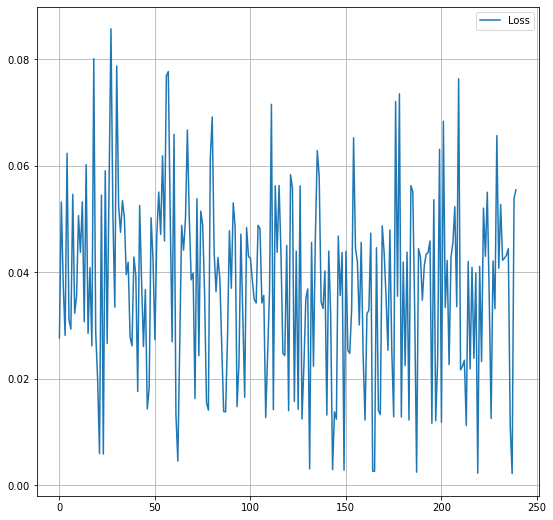

In [37]:
x = torch.arange(len(losses)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, temp_l, label="Loss")
ax.legend(loc='upper right')

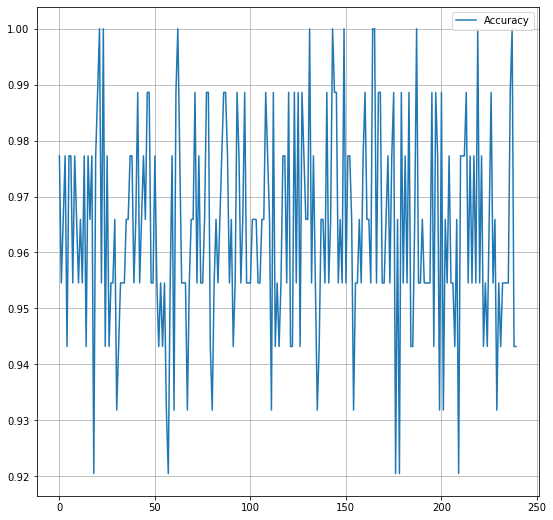

In [38]:
x = torch.arange(len(losses)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, temp_acc, label="Accuracy")
ax.legend(loc='upper right')

In [39]:
losses[-1], metrics[-1]

(tensor(0.0555, grad_fn=<MseLossBackward0>), 0.9431818181818182)

## TEST

In [40]:
test = DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [41]:
x,y=next(iter(test))

In [43]:
xy=model(x)

In [44]:
accuracy=M_accuracy(xy[0][0],y[0][0])
xy=(xy>=0.5).float()
correct = ((xy >=0.5) == y)

count = 4224000
count_t = (correct.float() == 1).sum()
count_f = (correct.float() == 0).sum()

In [45]:
accuracy , count_t/count, count_f/count

(0.9886363636363636, tensor(0.4833), tensor(0.0167))

In [48]:
xy[0][1], y[0][1]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [49]:
tx=xy.detach().numpy()
ty=y.detach().numpy()

In [50]:
N=np.array([])
for i in range(batch) :
    for j in range(1500) :
        ct=0;
        for k in range(88) : 
            if(tx[i][j][k] != ty[i][j][k]) :
                ct+=1
        N=np.append(N,ct)

print(N.mean())


2.944958333333333
